In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Input,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomUniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from prettytable import PrettyTable
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import datetime
from tensorflow.keras.callbacks import TensorBoard
from sklearn.ensemble import VotingClassifier
import joblib
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'CaseStudy')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


Continued from PART - 1

###Modelling

In [3]:
df = pd.read_excel('/content/gdrive/My Drive/CaseStudy/df_FEdone.xlsx')
#df.info()

In [4]:
df.columns

Index(['City', 'Zip Code', 'Senior Citizen', 'Partner', 'Dependents',
       'Multiple Lines', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Churn Value', 'Churn Score', 'CLTV', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Internet Type',
       'Avg Monthly GB Download', 'Streaming Music', 'Unlimited Data',
       'Total Revenue', 'Age', 'Married', 'Number of Dependents',
       'Satisfaction Score', 'Under65', 'MonthlyRevenue', 'Joined',
       'Electronic Check'],
      dtype='object')

Train Test Split

In [5]:
X = df.drop(['Churn Value'], axis=1)
y = df['Churn Value']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1,stratify=y)

In [7]:
# Save dataframes
X_train.to_excel('/content/gdrive/My Drive/CaseStudy/Xtrain_raw.xlsx',index=False)
X_test.to_excel('/content/gdrive/My Drive/CaseStudy/Xtest_raw.xlsx',index=False)
y_train.to_excel('/content/gdrive/My Drive/CaseStudy/ytrain_raw.xlsx',index=False)
y_test.to_excel('/content/gdrive/My Drive/CaseStudy/ytest_raw.xlsx',index=False)

Now we will attempt Response coding for the Zip Code and City features.

In [8]:
def response_coding(feature_dictionary, feature):
  feat_zeros = []
  feat_ones = []
  for f in feature:
    if f not in (feature_dictionary.keys()): 
      # For datapoints in TEST but not in TRAIN dataset.
      feat_zeros.append(0.5)
      feat_ones.append(0.5)
      continue
    feat_zeros.append(feature_dictionary[f][0])
    feat_ones.append(feature_dictionary[f][1])
  return feat_zeros, feat_ones

In [9]:
# Response Coding for Zip Code Feature:
uniqueList = list(X_train['Zip Code'].unique())
feature_dictionary_zip = {}
for i in uniqueList:
  # Count of Unique ZipCodes in Train Dataset
  tc = X_train.loc[X_train['Zip Code']==i,'Zip Code'].count()
  # Count of Churn Value = 0, for the given ZipCode (Customer Stays)
  tc_zeros = y_train[(X_train.loc[X_train['Zip Code']==i].index)].loc[y_train==0].count() 
  # Count of Churn Value = 1, for the given ZipCode (Customer Churns)
  tc_ones = y_train[(X_train.loc[X_train['Zip Code']==i].index)].loc[y_train==1].count()
  feature_dictionary_zip[i] = (tc_zeros/tc,tc_ones/tc) 

# Append new features to Dataset
X_train_ZipStayRate, X_train_ZipChurnRate = response_coding(feature_dictionary_zip, X_train['Zip Code'])
X_train['ZipStayRate'] = X_train_ZipStayRate
X_train['ZipChurnRate'] = X_train_ZipChurnRate
X_test_ZipStayRate, X_test_ZipChurnRate = response_coding(feature_dictionary_zip, X_test['Zip Code'])
X_test['ZipStayRate'] = X_test_ZipStayRate
X_test['ZipChurnRate'] = X_test_ZipChurnRate

# Response Coding for City Feature:
uniqueList = list(X_train['City'].unique())
feature_dictionary_city = {}
for i in uniqueList:
  # Count of Unique Cities in Train Dataset
  tc = X_train.loc[X_train['City']==i,'City'].count()
  # Count of Churn Value = 0, for the given City (Customer Stays)
  tc_zeros = y_train[(X_train.loc[X_train['City']==i].index)].loc[y_train==0].count() 
  # Count of Churn Value = 1, for the given City (Customer Churns)
  tc_ones = y_train[(X_train.loc[X_train['City']==i].index)].loc[y_train==1].count()
  feature_dictionary_city[i] = (tc_zeros/tc,tc_ones/tc) 

# Append new features to Dataset
X_train_CityStayRate, X_train_CityChurnRate = response_coding(feature_dictionary_city, X_train['City'])
X_train['CityStayRate'] = X_train_CityStayRate
X_train['CityChurnRate'] = X_train_CityChurnRate
X_test_CityStayRate, X_test_CityChurnRate = response_coding(feature_dictionary_city, X_test['City'])
X_test['CityStayRate'] = X_test_CityStayRate
X_test['CityChurnRate'] = X_test_CityChurnRate
#numLst.extend(['ZipStayRate', 'ZipChurnRate', 'CityStayRate', 'CityChurnRate'])

In [10]:
# Drop the original Zip and City features - now that we have response coded them
X_train.drop(['Zip Code','City'], axis = 1, inplace=True)
X_test.drop(['Zip Code','City'], axis = 1, inplace=True)

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1638 to 2702
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Senior Citizen           5282 non-null   object 
 1   Partner                  5282 non-null   object 
 2   Dependents               5282 non-null   object 
 3   Multiple Lines           5282 non-null   object 
 4   Online Security          5282 non-null   object 
 5   Online Backup            5282 non-null   object 
 6   Device Protection        5282 non-null   object 
 7   Tech Support             5282 non-null   object 
 8   Streaming TV             5282 non-null   object 
 9   Streaming Movies         5282 non-null   object 
 10  Contract                 5282 non-null   object 
 11  Paperless Billing        5282 non-null   object 
 12  Payment Method           5282 non-null   object 
 13  Monthly Charges          5282 non-null   float64
 14  Churn Score          

In [12]:
X_train.head(3)

,Senior Citizen,Partner,Dependents,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Score,CLTV,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Internet Type,Avg Monthly GB Download,Streaming Music,Unlimited Data,Total Revenue,Age,Married,Number of Dependents,Satisfaction Score,Under65,MonthlyRevenue,Joined,Electronic Check,ZipStayRate,ZipChurnRate,CityStayRate,CityChurnRate
1638,Yes,No,No,No,No,No,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,89.55,73,3802,No,0,43,None,Fiber Optic,6,Yes,Yes,5538.91,74,No,0,1,No,128.811860,No,No,0.333333,0.666667,0.533333,0.466667
4760,No,Yes,No,No,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),95.95,20,5009,Yes,9,18,Offer D,Fiber Optic,7,Yes,Yes,2271.58,56,Yes,0,3,Yes,126.198889,No,No,0.750000,0.250000,0.750000,0.250000
3096,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,115.65,75,3974,No,0,45,None,Fiber Optic,30,Yes,Yes,6643.35,26,No,0,3,Yes,147.630000,No,Yes,1.000000,0.000000,0.712500,0.287500


In [13]:
X_test.head(3)

,Senior Citizen,Partner,Dependents,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Score,CLTV,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Internet Type,Avg Monthly GB Download,Streaming Music,Unlimited Data,Total Revenue,Age,Married,Number of Dependents,Satisfaction Score,Under65,MonthlyRevenue,Joined,Electronic Check,ZipStayRate,ZipChurnRate,CityStayRate,CityChurnRate
238,No,No,No,Yes,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),74.40,97,2054,No,0,3,None,Fiber Optic,24,No,Yes,287.26,32,No,0,3,Yes,95.753333,No,No,0.500000,0.500000,0.500000,0.500000
2858,No,Yes,No,No,Yes,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),73.05,28,4515,Yes,5,64,Offer B,DSL,71,Yes,Yes,6393.61,20,Yes,0,3,Yes,99.900156,No,No,1.000000,0.000000,1.000000,0.000000
4978,No,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,108.20,57,4773,Yes,10,72,None,Fiber Optic,71,Yes,Yes,8862.28,21,Yes,0,4,Yes,123.087222,No,Yes,0.666667,0.333333,0.683544,0.316456


In [14]:
objLst = list(X_train.select_dtypes(include=['object']).columns.sort_values())

In [15]:
numLst = list(X_train.select_dtypes(exclude=['object']).columns.sort_values())

In [16]:
ohe = OneHotEncoder(drop = 'first', sparse=False, handle_unknown = 'ignore')
X_train_ohe = ohe.fit_transform(X_train[objLst])
X_train_cat = pd.DataFrame(X_train_ohe,columns=ohe.get_feature_names_out(objLst))
X_test_ohe = ohe.transform(X_test[objLst])
X_test_cat = pd.DataFrame(X_test_ohe,columns=ohe.get_feature_names(objLst))

In [17]:
# Scale numerical features
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train[numLst])
X_train_num = pd.DataFrame(X_train_sc,columns=scaler.get_feature_names_out((numLst)))
X_test_sc = scaler.transform(X_test[numLst])
X_test_num = pd.DataFrame(X_test_sc,columns=scaler.get_feature_names_out((numLst)))

In [18]:
X_train = pd.concat([X_train_cat, X_train_num], axis=1)
X_test = pd.concat([X_test_cat, X_test_num], axis=1)

In [19]:
X_test.columns

Index(['Contract_One year', 'Contract_Two year', 'Dependents_Yes',
       'Device Protection_No internet service', 'Device Protection_Yes',
       'Electronic Check_Yes', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Internet Type_None', 'Joined_Yes',
       'Married_Yes', 'Multiple Lines_No phone service', 'Multiple Lines_Yes',
       'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D',
       'Offer_Offer E', 'Online Backup_No internet service',
       'Online Backup_Yes', 'Online Security_No internet service',
       'Online Security_Yes', 'Paperless Billing_Yes', 'Partner_Yes',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check',
       'Referred a Friend_Yes', 'Senior Citizen_Yes',
       'Streaming Movies_No internet service', 'Streaming Movies_Yes',
       'Streaming Music_Yes', 'Streaming TV_No internet service',
       'Streaming TV_Yes', 'Tech Support_No internet service',
       '

In [20]:
# Save the dataframes.
X_train.to_excel('/content/gdrive/My Drive/CaseStudy/Xtrain.xlsx',index=False)
X_test.to_excel('/content/gdrive/My Drive/CaseStudy/Xtest.xlsx',index=False)
y_train.to_excel('/content/gdrive/My Drive/CaseStudy/ytrain.xlsx',index=False)
y_test.to_excel('/content/gdrive/My Drive/CaseStudy/ytest.xlsx',index=False)


In [21]:
'''
X_train = pd.read_excel('/content/gdrive/My Drive/CaseStudy/Xtrain.xlsx')
X_test = pd.read_excel('/content/gdrive/My Drive/CaseStudy/Xtest.xlsx')
y_train = pd.read_excel('/content/gdrive/My Drive/CaseStudy/ytrain.xlsx')
y_test = pd.read_excel('/content/gdrive/My Drive/CaseStudy/ytest.xlsx')
'''

"\nX_train = pd.read_excel('/content/gdrive/My Drive/CaseStudy/Xtrain.xlsx')\nX_test = pd.read_excel('/content/gdrive/My Drive/CaseStudy/Xtest.xlsx')\ny_train = pd.read_excel('/content/gdrive/My Drive/CaseStudy/ytrain.xlsx')\ny_test = pd.read_excel('/content/gdrive/My Drive/CaseStudy/ytest.xlsx')\n"

Metrics Choice:

The key aim of our classification problem is to let the service provider know before hand, the customer/set of customers who are likely to leave them and churn.

Given this, it is clear that we can live with a few false positives(CHURN) - as it would only mean, the company takes affirmative action to retain them, an would only increase their experience even further.

On the other hand if we have a lot of false Negatives (NO CHURN) the company might miss out on business/Revenue critical customers whom the model did not flag as high risk - but in reality were.

Recall is also not affected by the class imbalance, as in our case.

Hence using Recall as a primary metric to evaluvate and compare model performances would be a good and relevant idea.

We would use Recall would also be a good metric, as a safety net against False Negatives. We want to minimize the cases, where the model predicts a customer would not leave, but actually leaves. 

Apart from this we will also use Precision score and F1-Score as secondary metrics to evaluvate the model performances in terms of false positives.

We will also try to tune the threshold value for classification and use the best threshold based on the maximum TPR*(1-FPR) value. We find the optimal threshold instead of the default 0.5 as this is an imbalanced classification problem.

Term tpr*(1-fpr) increases with increasing tpr and decreasing fpr. We want the highest value of this term possible for the given values

In [22]:
def find_best_threshold(fpr, tpr, threshold):
  t = threshold[np.argmax(tpr*(1-fpr))]
  print('The maxiumum threshold is: {} for maximum TPR*(1-FPR) {}'.format(np.round(t,3),max(tpr*(1-fpr))))
  return t

def predict_useBest_t(threshold, prob):
  predictionList = []
  for i in prob:
       if i>=threshold:
           # Probability >= best threshold
           predictionList.append(1) 
       else:
           predictionList.append(0)
  return predictionList

def processMetrics(alg,y_test,y_pred_proba):

  test_fpr, test_tpr, test_thresh = roc_curve(y_test, y_pred_proba)
  best_t = find_best_threshold(test_fpr, test_tpr,test_thresh)
  y_pred = predict_useBest_t(best_t, y_pred_proba)

  print('-'*25, alg, '-'*25)
  # Recall Score
  recallScore = np.round(recall_score(y_test, y_pred),3)
  # Precision Score
  precisionScore  = np.round(precision_score(y_test, y_pred),3)
  # F1 Score
  f1Score = np.round(f1_score(y_test, y_pred),3)

  print("Recall Score: ",recallScore)
  print("Precision Score: ",precisionScore)
  print("F1-Score: ",f1Score)

  # Confusion Matrix
  cm = confusion_matrix(y_test,y_pred)
  print('\n'+' '*13 + "Confusion Matrix")
  sns.heatmap(cm, annot=True,fmt="d",cmap='Greens',xticklabels=['PRED-NO', 'PRED-YES'],yticklabels=['ACT-NO', 'ACT-YES'])
  plt.show()

  # Precison Matrix
  pr = cm/cm.sum(axis=0) # Normalize with column sum
  print('\n'+' '*13 + "Precision Matrix")
  sns.heatmap(pr, annot=True,fmt=".3f",cmap='Greens',xticklabels=['PRED-NO', 'PRED-YES'],yticklabels=['ACT-NO', 'ACT-YES'])
  plt.show()

  # Recall Matrix
  re = (cm.T/cm.sum(axis=1)).T # Normalize with row sum. 
  print('\n'+' '*13 + "Recall Matrix")
  sns.heatmap(re, annot=True,fmt=".3f",cmap='Greens',xticklabels=['PRED-NO', 'PRED-YES'],yticklabels=['ACT-NO', 'ACT-YES'])
  plt.show()

  # Precision Recall Curve
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
  plt.plot(recall, precision, 'g-', label='Recall: '+str(recallScore))
  plt.title(alg+'- Precision-Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend()
  plt.show()

  return best_t, recallScore, precisionScore, f1Score

In [23]:
def featureImportance(alg, feature_weights):
  impFeat =  list(feature_weights.sort_values(ascending = False)[:15].index)
  print(alg, '- Top 15 important features: ')
  feature_weights.sort_values(ascending = False)[:15].plot(kind='bar')
  plt.show()
  return impFeat

In [24]:
modelList = {}
recallDict = {}
precisionDict = {}
f1scoreDict = {}
impFeatures = {}
best_tDict = {}

##1. Random Model

Let us try to get the worst case scenario, with a random model that predicts the class label based on the distribution of the individual class labels in the Train dataset

In [25]:
alg = 'RANDOM MODEL'

In [26]:
modelRM = DummyClassifier(strategy='stratified', random_state=1)
modelRM.fit(X_train, y_train)

DummyClassifier(random_state=1, strategy='stratified')

In [27]:
y_pred = modelRM.predict(X_test)
y_pred_proba = modelRM.predict_proba(X_test)[:,1]

The maxiumum threshold is: 1.0 for maximum TPR*(1-FPR) 0.2153473948283794
------------------------- RANDOM MODEL -------------------------
Recall Score:  0.296
Precision Score:  0.282
F1-Score:  0.289

             Confusion Matrix


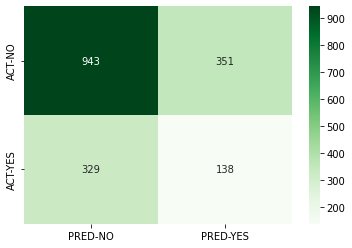


             Precision Matrix


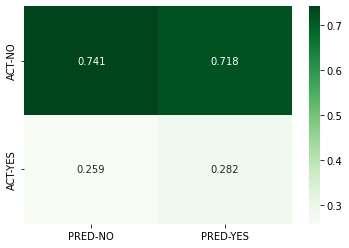


             Recall Matrix


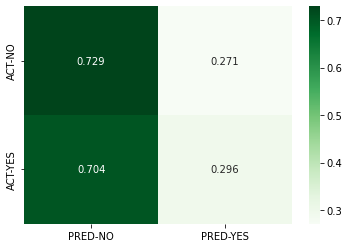

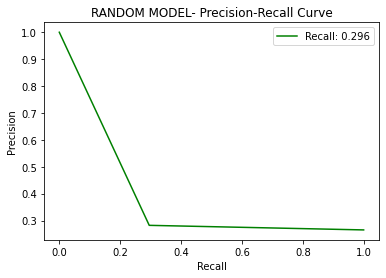

In [28]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test,y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t


## 2. KNN

In [29]:
alg = 'KNN'

In [30]:
# Hyper Parameter/s Tuning
classifier = KNeighborsClassifier()
parameters = {'n_neighbors': np.arange(1, 50, 2)}
grid_cv = GridSearchCV(classifier, parameters, cv=5, scoring='recall', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestn_neighbors = grid_cv.best_params_['n_neighbors']

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters:  {'n_neighbors': 9}


In [31]:
modelKNN = KNeighborsClassifier(n_neighbors=bestn_neighbors,n_jobs=-1 )
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=9)

In [32]:
y_pred = modelKNN.predict(X_test)
y_pred_proba = modelKNN.predict_proba(X_test)[:,1]

The maxiumum threshold is: 0.333 for maximum TPR*(1-FPR) 0.6991616718903587
------------------------- KNN -------------------------
Recall Score:  0.861
Precision Score:  0.623
F1-Score:  0.723

             Confusion Matrix


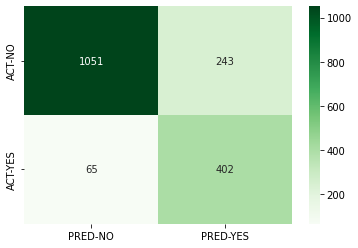


             Precision Matrix


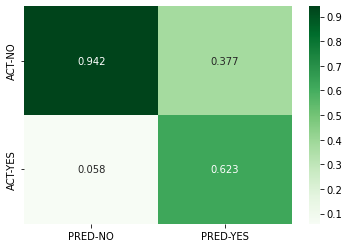


             Recall Matrix


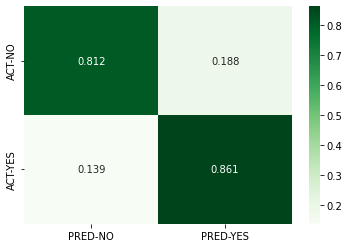

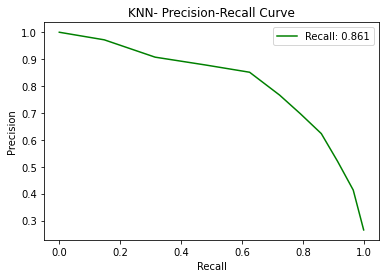

In [33]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test, y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t

##2. Logistic Regression

In [34]:
alg = 'LOGISTIC REGRESSION'

In [35]:
# Hyper Parameter/s Tuning
classifier = LogisticRegression()
parameters = {'C': np.arange(0.1, 3.0, 0.2)}
grid_cv = GridSearchCV(classifier, parameters, cv=5, scoring='recall', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestC = grid_cv.best_params_['C']

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters:  {'C': 2.900000000000001}


In [36]:
modelLR = LogisticRegression(C=bestC, random_state=1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=2.900000000000001, random_state=1)

In [37]:
y_pred = modelLR.predict(X_test)
y_pred_proba = modelLR.predict_proba(X_test)[:,1]

The maxiumum threshold is: 0.091 for maximum TPR*(1-FPR) 0.9241135995816633
------------------------- LOGISTIC REGRESSION -------------------------
Recall Score:  0.985
Precision Score:  0.852
F1-Score:  0.914

             Confusion Matrix


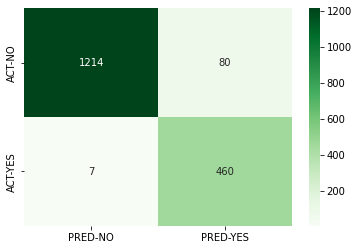


             Precision Matrix


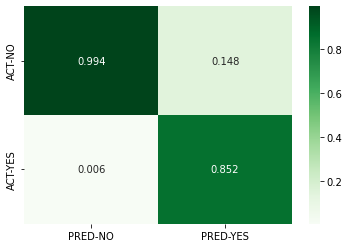


             Recall Matrix


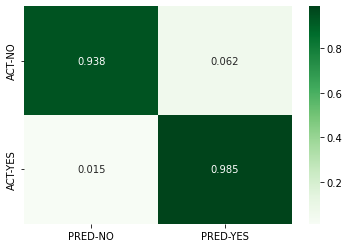

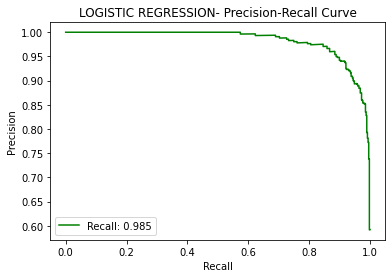

In [38]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test, y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t

LOGISTIC REGRESSION - Top 15 important features: 


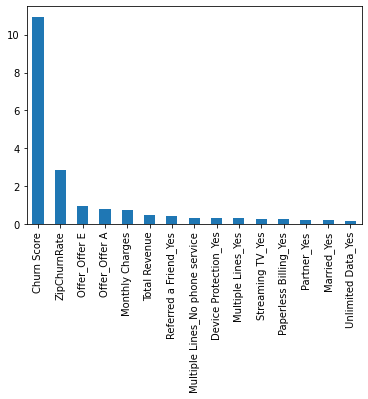

In [39]:
feature_weights = pd.Series(data = modelLR.coef_[0], index = X_train.columns)
impFeatures[alg] = featureImportance(alg, feature_weights)

##2. SVC

In [40]:
alg = 'SVC'

In [41]:
# Hyper Parameter/s Tuning
classifier = SVC(random_state=1,  probability=True, kernel='rbf', gamma='scale')
parameters = {'C': [1e-5,1e-4,1e-3,1e-1,1e-0,1e+1,1e+2,1e+3,1e+4,1e+5]}
GridSearchCV(classifier, parameters, cv=5, scoring='recall', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestC = grid_cv.best_params_['C']

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters:  {'C': 2.900000000000001}


In [42]:
modelSVC = SVC(C=bestC, random_state=1,  probability=True, kernel='rbf', gamma='scale')
modelSVC.fit(X_train, y_train)

SVC(C=2.900000000000001, probability=True, random_state=1)

In [43]:
y_pred = modelSVC.predict(X_test)
y_pred_proba = modelSVC.predict_proba(X_test)[:,1]

The maxiumum threshold is: 0.167 for maximum TPR*(1-FPR) 0.8982654253365062
------------------------- SVC -------------------------
Recall Score:  0.934
Precision Score:  0.899
F1-Score:  0.916

             Confusion Matrix


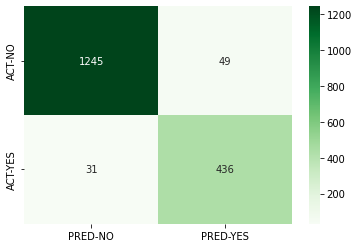


             Precision Matrix


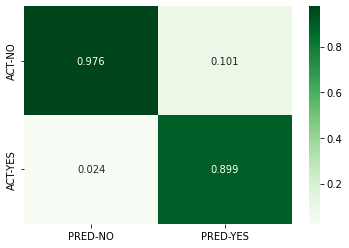


             Recall Matrix


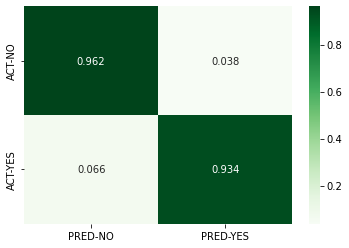

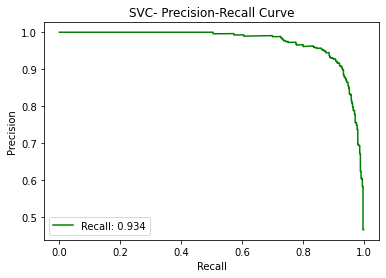

In [44]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test,y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t

##3. Naive Bayes

In [45]:
alg = 'NAIVE BAYES'

In [46]:
# Hyper Parameter/s Tuning
classifier = MultinomialNB(fit_prior = True)
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
grid_cv = GridSearchCV(classifier, parameters, cv=5, scoring='recall', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestAlpha = grid_cv.best_params_['alpha']

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best Parameters:  {'alpha': 10}


In [47]:
modelNB = MultinomialNB(alpha = bestAlpha, fit_prior = True) 
modelNB.fit(X_train, y_train)

MultinomialNB(alpha=10)

In [48]:
y_pred = modelNB.predict(X_test)
y_pred_proba = modelNB.predict_proba(X_test)[:,1]

The maxiumum threshold is: 0.297 for maximum TPR*(1-FPR) 0.6392905487027923
------------------------- NAIVE BAYES -------------------------
Recall Score:  0.861
Precision Score:  0.547
F1-Score:  0.669

             Confusion Matrix


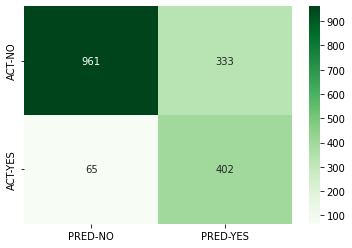


             Precision Matrix


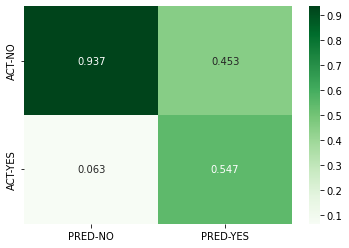


             Recall Matrix


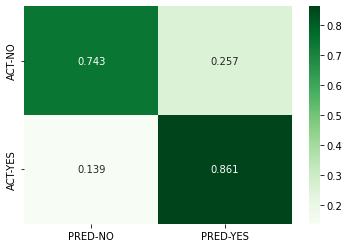

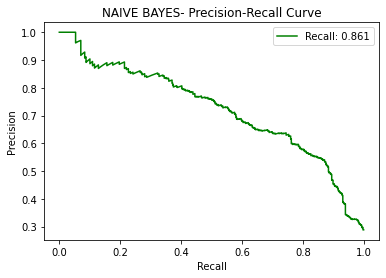

In [49]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test,y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t

POSITIVE CLASS
NAIVE BAYES - Top 15 important features: 


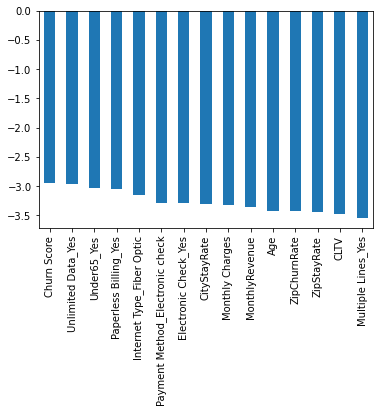

NEGATIVE CLASS
NAIVE BAYES - Top 15 important features: 


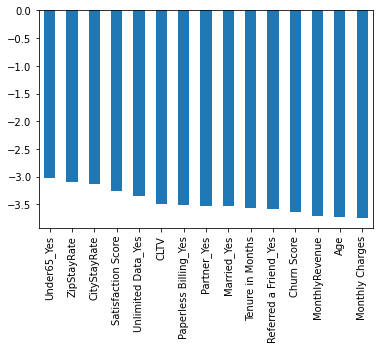

In [50]:
# Positive Class
print('POSITIVE CLASS')
feature_weights = pd.Series(data = modelNB.feature_log_prob_[1,:], index = X_train.columns)
impFeatures[alg] = featureImportance(alg, feature_weights)

# Negative Class
print('NEGATIVE CLASS')
feature_weights = pd.Series(data = modelNB.feature_log_prob_[0,:], index = X_train.columns)
impFeatures[alg] = impFeatures[alg] + featureImportance(alg, feature_weights)

##3. Decision Tree

In [51]:
alg = 'DECISION TREE'

In [52]:
# Hyper Parameter/s Tuning
classifier = DecisionTreeClassifier(random_state = 1)
parameters = {'max_depth':[1, 5, 10, 50, None], 'min_samples_split':[2, 5, 10, 100, 500], 'min_samples_leaf':[1, 5, 10, 100, 500]}
grid_cv = GridSearchCV(classifier, parameters, cv=5, scoring='recall', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestmax_depth = grid_cv.best_params_['max_depth']
bestmin_samples_leaf = grid_cv.best_params_['min_samples_leaf']
bestmin_samples_split = grid_cv.best_params_['min_samples_split']

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best Parameters:  {'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [53]:
modelDT = DecisionTreeClassifier(max_depth= bestmax_depth, min_samples_leaf= bestmin_samples_leaf, min_samples_split= bestmin_samples_split, random_state = 1)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, min_samples_leaf=5, random_state=1)

In [54]:
y_pred = modelDT.predict(X_test)
y_pred_proba = modelDT.predict_proba(X_test)[:,1]

The maxiumum threshold is: 0.2 for maximum TPR*(1-FPR) 0.874786942865937
------------------------- DECISION TREE -------------------------
Recall Score:  0.946
Precision Score:  0.819
F1-Score:  0.878

             Confusion Matrix


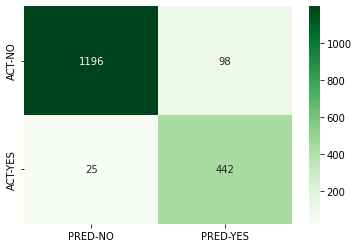


             Precision Matrix


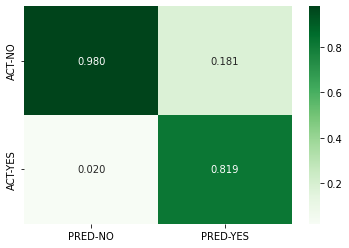


             Recall Matrix


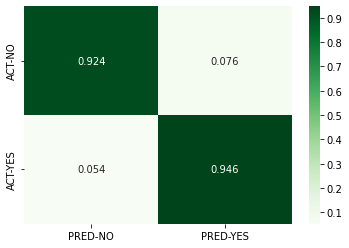

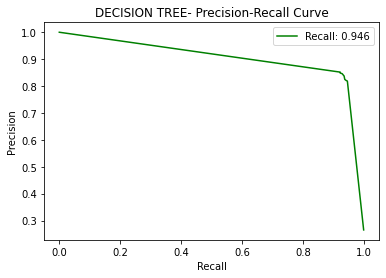

In [55]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test,y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t

DECISION TREE - Top 15 important features: 


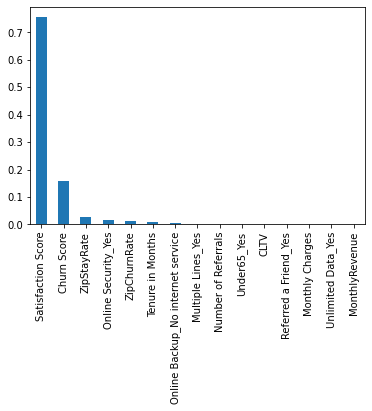

In [56]:
feature_weights = pd.Series(data = modelDT.feature_importances_, index = X_train.columns)
impFeatures[alg] = featureImportance(alg, feature_weights)

##4. Random Forest

In [57]:
alg = 'RANDOM FOREST'

In [58]:
# Hyper Parameter/s Tuning
classifier = RandomForestClassifier(random_state = 1)
parameters = {'n_estimators': [100, 500, 1000], 'min_samples_split':[2, 5, 10]}
grid_cv = GridSearchCV(classifier, parameters, cv=5, scoring='recall', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestmin_samples_split = grid_cv.best_params_['min_samples_split']
bestn_estimators = grid_cv.best_params_['n_estimators']

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters:  {'min_samples_split': 5, 'n_estimators': 500}


In [59]:
modelRF = RandomForestClassifier(min_samples_split= bestmin_samples_split, n_estimators= bestn_estimators, random_state = 1)
modelRF.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=500, random_state=1)

In [60]:
y_pred = modelRF.predict(X_test)
y_pred_proba = modelRF.predict_proba(X_test)[:,1]

The maxiumum threshold is: 0.368 for maximum TPR*(1-FPR) 0.9147076442417482
------------------------- RANDOM FOREST -------------------------
Recall Score:  0.938
Precision Score:  0.932
F1-Score:  0.935

             Confusion Matrix


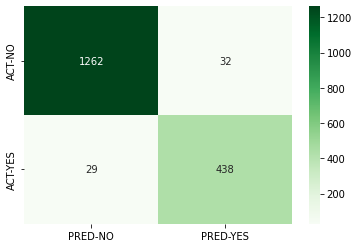


             Precision Matrix


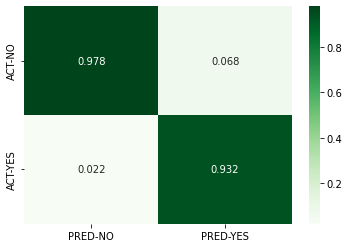


             Recall Matrix


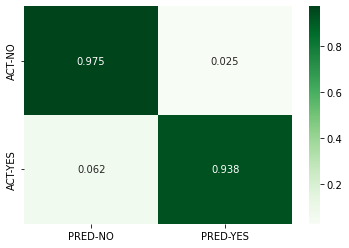

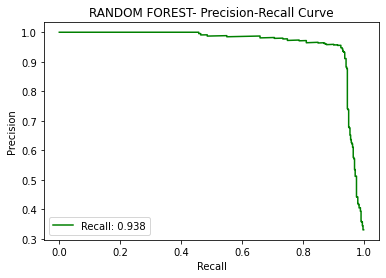

In [61]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test, y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t

RANDOM FOREST - Top 15 important features: 


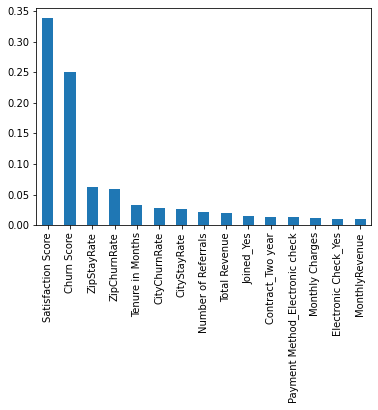

In [62]:
feature_weights = pd.Series(data = modelRF.feature_importances_, index = X_train.columns)
impFeatures[alg] = featureImportance(alg, feature_weights)

##4. Gradient Boosting

In [63]:
alg = 'GBDT'

In [64]:
# Hyper Parameter/s Tuning
classifier = XGBClassifier(random_state = 1)
parameters = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators':[5,10,50, 75, 100, 200]}
grid_cv = GridSearchCV(classifier, parameters, cv=5, scoring='recall', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestlearning_rate = grid_cv.best_params_['learning_rate']
bestn_estimators = grid_cv.best_params_['n_estimators']

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters:  {'learning_rate': 0.1, 'n_estimators': 100}


In [65]:
modelXGB = XGBClassifier(learning_rate = bestlearning_rate, n_estimators=bestn_estimators, random_state = 1 )
modelXGB.fit(X_train, y_train)

XGBClassifier(random_state=1)

In [66]:
y_pred = modelXGB.predict(X_test)
y_pred_proba = modelXGB.predict_proba(X_test)[:,1]

The maxiumum threshold is: 0.04800000041723251 for maximum TPR*(1-FPR) 0.9272924947625178
------------------------- GBDT -------------------------
Recall Score:  0.97
Precision Score:  0.888
F1-Score:  0.927

             Confusion Matrix


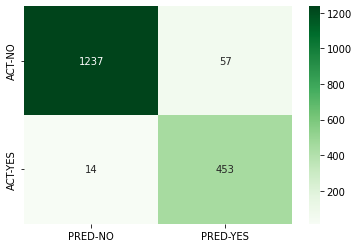


             Precision Matrix


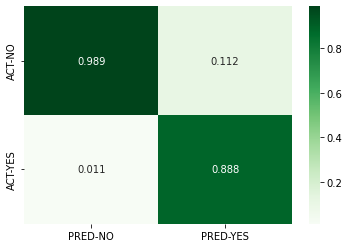


             Recall Matrix


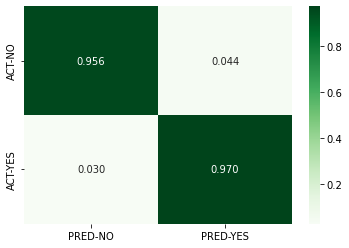

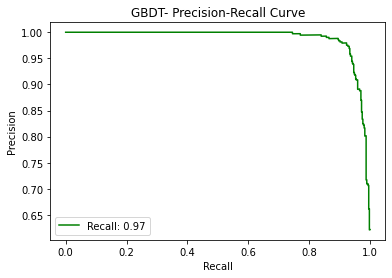

In [67]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test, y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t

GBDT - Top 15 important features: 


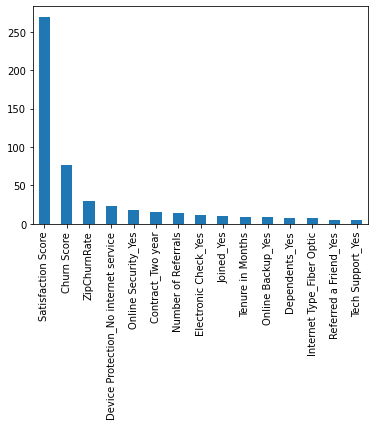

In [68]:
feature_weights = pd.Series(data = modelXGB.get_booster().get_score(importance_type='gain'), index = X_train.columns)
impFeatures[alg] = featureImportance(alg, feature_weights)

## 5. Ensemble - Voting Classifier

Going by the main metric for our solution: Recall Scores - these models have performed well: Logistic Regression, Decision Tree  and GBDT.

We will get the top 15 important features for these algorithms and try to combine them into an ensemble and see if the performance gets better.

In [69]:
alg = 'ENSEMBLE VOTE CLF'

In [70]:
important_features = set()

In [71]:
for m in ['LOGISTIC REGRESSION','DECISION TREE','GBDT']:
  for feat in impFeatures[m]:
    important_features.add(feat)
print(len(important_features))
important_features

32


{'CLTV',
 'Churn Score',
 'Contract_Two year',
 'Dependents_Yes',
 'Device Protection_No internet service',
 'Device Protection_Yes',
 'Electronic Check_Yes',
 'Internet Type_Fiber Optic',
 'Joined_Yes',
 'Married_Yes',
 'Monthly Charges',
 'MonthlyRevenue',
 'Multiple Lines_No phone service',
 'Multiple Lines_Yes',
 'Number of Referrals',
 'Offer_Offer A',
 'Offer_Offer E',
 'Online Backup_No internet service',
 'Online Backup_Yes',
 'Online Security_Yes',
 'Paperless Billing_Yes',
 'Partner_Yes',
 'Referred a Friend_Yes',
 'Satisfaction Score',
 'Streaming TV_Yes',
 'Tech Support_Yes',
 'Tenure in Months',
 'Total Revenue',
 'Under65_Yes',
 'Unlimited Data_Yes',
 'ZipChurnRate',
 'ZipStayRate'}

In [72]:
estimators = [('LOGISTIC REGRESSION',modelLR),('DECISION TREE',modelDT),('GBDT',modelXGB)]

In [73]:
modelVote = VotingClassifier(estimators, voting='soft')
modelVote.fit(X_train[important_features], y_train)

VotingClassifier(estimators=[('LOGISTIC REGRESSION',
                              LogisticRegression(C=2.900000000000001,
                                                 random_state=1)),
                             ('DECISION TREE',
                              DecisionTreeClassifier(max_depth=50,
                                                     min_samples_leaf=5,
                                                     random_state=1)),
                             ('GBDT', XGBClassifier(random_state=1))],
                 voting='soft')

In [74]:
y_pred = modelVote.predict(X_test[important_features])
y_pred_proba = modelVote.predict_proba(X_test[important_features])[:,1]

The maxiumum threshold is: 0.457 for maximum TPR*(1-FPR) 0.9226077200321695
------------------------- ENSEMBLE VOTE CLF -------------------------
Recall Score:  0.94
Precision Score:  0.948
F1-Score:  0.944

             Confusion Matrix


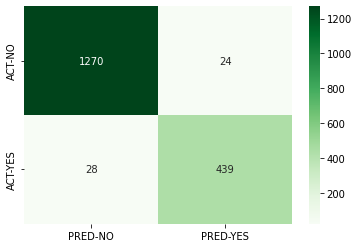


             Precision Matrix


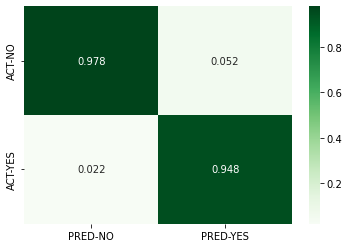


             Recall Matrix


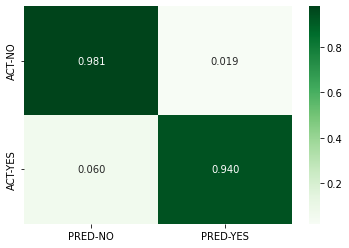

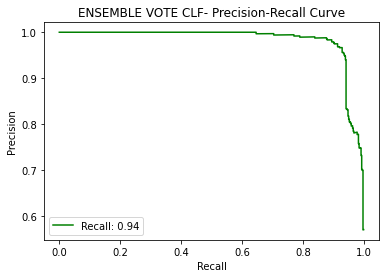

In [75]:
best_t, recallScore, precisionScore, f1Score = processMetrics(alg,y_test, y_pred_proba)
recallDict[alg] = recallScore
precisionDict[alg] = precisionScore
f1scoreDict[alg] = f1Score
best_tDict[alg] = best_t

We see that in terms of recall score this ensemble does not outperform the best performing models.

###5. ANN

Now we will try training a simple Neural Network and see if the performance is better than the above ML models.

In [ ]:
alg = 'ANN'

In [ ]:
input_dim = X_train.shape[1]

In [ ]:
modelANN = Sequential()
modelANN.add(Dense(128, activation='relu', input_shape=(input_dim,), kernel_initializer=tf.keras.initializers.HeUniform()))
modelANN.add(Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
modelANN.add(Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
modelANN.add(Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
modelANN.add(Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
modelANN.add(Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeUniform()))
modelANN.add(Dense(1, activation='sigmoid'))
modelANN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6912      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [ ]:
# Compile the model
modelANN.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.Recall(name='recall')])

In [ ]:
# Save Model Check points
filepath="model_save/weights-{epoch:02d}-{val_recall:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor= 'val_recall', verbose=1, save_best_only=True, mode='max')

# Early Stop
earlystop = EarlyStopping(monitor='val_recall', patience=5, verbose=1, mode='max')

callback_list = [earlystop, checkpoint]

In [ ]:
# fit the model
scores = modelANN.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=16,callbacks =callback_list)

Epoch 1/100
326/331 [============================>.] - ETA: 0s - loss: 0.1444 - recall: 0.8745
Epoch 1: val_recall improved from -inf to 0.85653, saving model to model_save/weights-01-0.8565.hdf5
331/331 [==============================] - 4s 9ms/step - loss: 0.1442 - recall: 0.8745 - val_loss: 0.1627 - val_recall: 0.8565
Epoch 2/100
330/331 [============================>.] - ETA: 0s - loss: 0.0636 - recall: 0.9551
Epoch 2: val_recall improved from 0.85653 to 0.86724, saving model to model_save/weights-02-0.8672.hdf5
331/331 [==============================] - 3s 8ms/step - loss: 0.0636 - recall: 0.9551 - val_loss: 0.1434 - val_recall: 0.8672
Epoch 3/100
329/331 [============================>.] - ETA: 0s - loss: 0.0484 - recall: 0.9627
Epoch 3: val_recall did not improve from 0.86724
331/331 [==============================] - 3s 8ms/step - loss: 0.0482 - recall: 0.9629 - val_loss: 0.2146 - val_recall: 0.8501
Epoch 4/100
326/331 [============================>.] - ETA: 0s - loss: 0.0373 - 

In [ ]:
np.round(max(scores.history['val_recall']),3)

0.923

In [ ]:
recallScoreANN = np.round(max(scores.history['val_recall']),3)

## Summary

Let us now see a summary of the primary metric - Recall and other secondary metrics to measure and compare our model performances.

In [76]:
pt = PrettyTable()
pt.field_names = ['Model', 'Recall Score (Primary Metric)', 'Precision Score', 'F1-Score']
for key in recallDict.keys():
  pt.add_row([key,recallDict[key],precisionDict[key],f1scoreDict[key]])
print(pt)

+---------------------+-------------------------------+-----------------+----------+
|        Model        | Recall Score (Primary Metric) | Precision Score | F1-Score |
+---------------------+-------------------------------+-----------------+----------+
|     RANDOM MODEL    |             0.296             |      0.282      |  0.289   |
|         KNN         |             0.861             |      0.623      |  0.723   |
| LOGISTIC REGRESSION |             0.985             |      0.852      |  0.914   |
|         SVC         |             0.934             |      0.899      |  0.916   |
|     NAIVE BAYES     |             0.861             |      0.547      |  0.669   |
|    DECISION TREE    |             0.946             |      0.819      |  0.878   |
|    RANDOM FOREST    |             0.938             |      0.932      |  0.935   |
|         GBDT        |              0.97             |      0.888      |  0.927   |
|  ENSEMBLE VOTE CLF  |              0.94             |      0.94

In [ ]:
pt = PrettyTable()
pt.field_names = ['Model', 'Recall Score']
pt.add_row(['ANN',recallScoreANN])
print(pt)

+-------+--------------+
| Model | Recall Score |
+-------+--------------+
|  ANN  |    0.923     |
+-------+--------------+


From the outset it is looks like Logistic Regression has the best Recall Score followed closely by GBDT. However, the precision score of GBDT is significantly higher than the Logistic Regression Model. Hence GBDT model gives a better balance in terms of precision and recall - Hence it makes sense to consider this model to be best performing, among the models we saw above.

The next models like Ensemble and Decision Tree have a significant drop in the recall values, which, as we discussed earlier would not fit our business requirement of minimizing the False Negatives to the best extent possible.

Since GBDT for small drop in recall gives a significant improvement in the precision - gives the best possible balance - we will use it for deploy.

ANN does not out perform the best ML models.

We will deploy the GBDT model.

We will dump the model and other information we need for the deploy below:

In [ ]:
# Save the best Model/s
#modelXGB.save_model("/content/gdrive/My Drive/CaseStudy/deploy/modelXGB.json")
modelXGB.save_model("/content/gdrive/My Drive/CaseStudy/deploy/modelXGB.txt")
# Save the best threshold
joblib.dump(best_tDict['GBDT'], open('/content/gdrive/My Drive/CaseStudy/deploy/best_t.pkl','wb'))
# Save MinMaxScaler
joblib.dump(scaler, open('/content/gdrive/My Drive/CaseStudy/deploy/scaler.pkl','wb'))
# Save OHE
joblib.dump(ohe, open('/content/gdrive/My Drive/CaseStudy/deploy/ohe.pkl','wb'))
# Save response coding feature dictionaries - Zip Code and City
joblib.dump(feature_dictionary_city, open('/content/gdrive/My Drive/CaseStudy/deploy/feature_dictionary_city.pkl','wb'))
joblib.dump(feature_dictionary_zip, open('/content/gdrive/My Drive/CaseStudy/deploy/feature_dictionary_zip.pkl','wb'))
